# **Polar Express**
----------------
##### **Paolini Lorenzo** - Matricola n. 0001056503

The following notebook is divided into 4 different sections:
- **Section 1**: Definition of all the functions that will be used to build, train and evaluate the model. `polar_generator` is the default function, it has not been modified. In this section you will find the functions `compute_accuracy` (*useful to compute the accuracy of the model*), `plot_history` (*useful to plot the accuracy and loss lines during the training step*), and the two functions `earlystopping` and `reduce_lr` (both these functions are `callback` functions and are useful to, respectively, *stop the training process if the model starts to go in overfitting*, and to *dynamically scale by a factor of* 0.1 *the learning rate of the model if there is the possibility that it is stuck in a plateau*);
- **Section 2**: Definition of the model, model summary, and hyperparameters settings;
- **Section 3**: Training process, history of training, accuracy and loss plots on validation set;
- **Section 4**: Contains the evaluation of the model done by the previously defined accuracy function. The function returns the number of prediction done by the network, the number of correct predictions, the accuracy (in percentage) of the model, and whether it satisfies or not the basic requirement of a 95% accuracy.

<font color="red"><b><i>Pay attention: I have used the Flat variant of the generator by setting `flat=True` in all the instances of the generator</i></b></font>

In [1]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv2D, Flatten, Dense, concatenate, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras import callbacks
import matplotlib.pyplot as plt

## **Section 1**: Functions

#### Generator
It is the original generator, treated as a black box and not modified.

In [2]:
def polar_generator(batchsize,grid=(10,10),noise=.002,flat=False):
  while True:
    x = np.random.rand(batchsize)
    y = np.random.rand(batchsize)
    out = np.zeros((batchsize,grid[0],grid[1]))
    xc = (x*grid[0]).astype(int)
    yc = (y*grid[1]).astype(int)
    for b in range(batchsize):
      out[b,xc[b],yc[b]] = 1
    #compute rho and theta and add some noise
    rho = np.sqrt(x**2+y**2) + np.random.normal(scale=noise)
    theta = np.arctan(y/np.maximum(x,.00001)) + np.random.normal(scale=noise)
    if flat:
      out = np.reshape(out,(batchsize,grid[0]*grid[1]))
    yield ((theta,rho),out)

#### Visualization function

In [3]:
# Visualization of training parameters function
################################################################################

def plot_history(history):
    """
    plot_history takes in input the history record of the model
    It computes the accuracy line on validation set per epoch, and the loss line per epoch
    """
    print(history.history.keys())
    # summarize history for categorical_accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

#### Accuracy function

In [16]:
# Accuracy function
################################################################################

def compute_accuracy(model, generator, test_sample_size):
    """
    The function takes in input the model, the generator, and the number of samples 
    you want to use to evaluate the accuracy of the model.
    """
    test_gen = polar_generator(batchsize=test_sample_size, grid=(10,10), flat=True)
    (theta, rho), maps = next(test_gen)
    pred = model.predict([theta, rho])
    n_correct_guess = 0
    for i, map in enumerate(pred):
      if np.argmax(map) == np.argmax(maps[i]):
          n_correct_guess+=1
    model_accuracy = 100*(n_correct_guess/len(maps))
    print("Over {} predictions done by the model,".format(len(maps)))
    print("The number of correct guesses is {}.".format(n_correct_guess))
    print("\n")
    print("Thus resulting in a {:.2f}% of accuracy.".format(model_accuracy))
    print("\n")
    if model_accuracy >= 95:
      basic_requirements = True
    else:
      basic_requirements = False
    print("The model {} satisfies the basic requirements: {}".format(model, basic_requirements))
    return basic_requirements

#### Callback functions
As specified in the introduction, this section contains the definition of 2 callback functions.

In [7]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="auto", patience = 16, 
                                        restore_best_weights = True)

In [6]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                        patience=4, min_lr=0.000001)

## **Section 2**: Model

#### Model definition
I have decided to concatenate the two inputs (theta and rho), and to reshape their dimension into a (1,1,2) grid (basically a 2D grid). This has been done in order to use two 2D convolutional layers to extract the main features of the input, the first composed by a (1,1) kernel, applying three filters, and the second by six filters and a (1,1) kernel again. Additionally, I have defined a  Flatten layer to reshape the output of the previous convolutional layer to a one-dimension array that could be processed by the output layer, which is a Dense layer, aimed to produce the probability mapping of the prediction. </br></br>
The optimizer I have used is `Adam`, and I have set the initial learning rate to 0.01.</br></br>
The activation functions of the two convolutional layers are, respectively, the `tanh` and the `relu` functions, while to compute the final prediction I have used the `softmax` function, in order to produce a probability mapping into the 100 values array. The loss function has been initialized to be the `categorical_crossentropy`.

In [8]:
##################################
# Model Name = Dual_conv_model
##################################

# Define optimizer and initial learning rate
optimizer = Adam(learning_rate=0.01)

# Define the inputs and concatenate them
theta = Input(shape=(1,))
rho = Input(shape=(1,))
concatenated_inputs = concatenate([theta, rho])

# Reshape input to a 2D grid
reshaping_layer = Reshape((1,1,2))(concatenated_inputs)

# Define the two convolutional layers
first_convolutional_layer = Conv2D(3, (1, 1), activation='tanh')(reshaping_layer)
second_convolutional_layer = Conv2D(6, (1, 1), activation='relu')(first_convolutional_layer)

# Flatten the output produced by the convolutional layers
flat_layer = Flatten()(second_convolutional_layer)

# Output Dense layer
output = Dense(100, activation='softmax')(flat_layer)

# Build and compile the model
Dual_conv_model = Model(inputs=[theta, rho], outputs=output)
Dual_conv_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Now, I print on screen the summary of the model.

In [9]:
Dual_conv_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 2)            0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1, 1, 2)      0           ['concatenate[0][0]']        

#### Setting hyperparameters 

In [10]:
batchsize = 128
epochs = 100
steps_per_epoch = 2000 
validation_steps = 200 

## **Section 3**: Training and history

#### Training

Thanks to the `early_stopping` function, the model will stop training before overfitting, and also before the entirety of the epochs.

In [11]:
# Training record
################################################################################

history = Dual_conv_model.fit(polar_generator(batchsize=batchsize, grid=(10,10), flat=True),
                              validation_data=polar_generator(batchsize=batchsize, grid=(10,10), flat=True), 
                              steps_per_epoch=steps_per_epoch, 
                              validation_steps=validation_steps, 
                              epochs=epochs,
                              shuffle=True, 
                              callbacks =[reduce_lr, earlystopping])

Epoch 1/100
2000/2000 [==============================] - 8s 4ms/step - loss: 1.4803 - categorical_accuracy: 0.5602 - val_loss: 0.7924 - val_categorical_accuracy: 0.7757 - lr: 0.0100
Epoch 2/100
2000/2000 [==============================] - 6s 3ms/step - loss: 0.6913 - categorical_accuracy: 0.7647 - val_loss: 0.5921 - val_categorical_accuracy: 0.8031 - lr: 0.0100
Epoch 3/100
2000/2000 [==============================] - 7s 3ms/step - loss: 0.5443 - categorical_accuracy: 0.8098 - val_loss: 0.5218 - val_categorical_accuracy: 0.8032 - lr: 0.0100
Epoch 4/100
2000/2000 [==============================] - 7s 3ms/step - loss: 0.4766 - categorical_accuracy: 0.8269 - val_loss: 0.4266 - val_categorical_accuracy: 0.8597 - lr: 0.0100
Epoch 5/100
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4330 - categorical_accuracy: 0.8392 - val_loss: 0.4011 - val_categorical_accuracy: 0.8504 - lr: 0.0100
Epoch 6/100
2000/2000 [==============================] - 7s 3ms/step - loss: 0.4024 - cate

#### History about accuracy on validation test, and plots

In [12]:
history.history["val_categorical_accuracy"]

[0.7756640911102295,
 0.8031250238418579,
 0.8032031059265137,
 0.8597265481948853,
 0.8503515720367432,
 0.8666406273841858,
 0.8633984327316284,
 0.8580468893051147,
 0.8603515625,
 0.8614843487739563,
 0.879687488079071,
 0.8680859208106995,
 0.8804296851158142,
 0.861132800579071,
 0.8933203220367432,
 0.8993750214576721,
 0.8829296827316284,
 0.8813281059265137,
 0.8932421803474426,
 0.8916015625,
 0.9434375166893005,
 0.9485156536102295,
 0.9442968964576721,
 0.9493749737739563,
 0.9483203291893005,
 0.9442577958106995,
 0.9415624737739563,
 0.9424609541893005,
 0.9460155963897705,
 0.9546874761581421,
 0.956250011920929,
 0.9587500095367432,
 0.9585156440734863,
 0.9568750262260437,
 0.9563281536102295,
 0.9555078148841858,
 0.9564062356948853,
 0.9566797018051147,
 0.9564062356948853,
 0.9610156416893005,
 0.9560937285423279,
 0.9584765434265137,
 0.9580859541893005,
 0.9578515887260437,
 0.9583203196525574,
 0.9578906297683716,
 0.9606249928474426,
 0.9563671946525574,
 0.9560

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


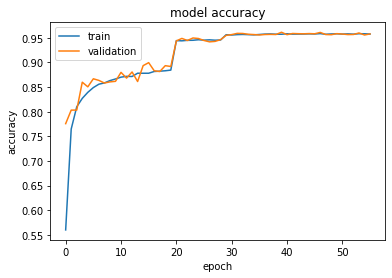

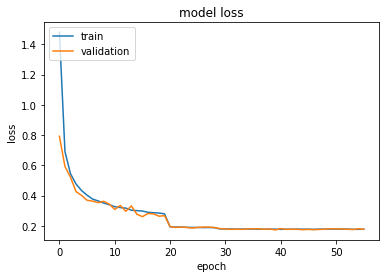

In [13]:
plot_history(history)

## **Section 4**: Evaluation of the model

The evaluation has been done on: **1000000 (one million)** samples

In [17]:
compute_accuracy(Dual_conv_model, polar_generator, 1000000)

31250/31250 [==============================] - 60s 2ms/step
Over 1000000 predictions done by the model,
The number of correct guesses is 964871.


Thus resulting in a 96.49% of accuracy.


The model <keras.engine.functional.Functional object at 0x7f7f2740e2b0> satisfies the basic requirements: True


True